# Distinguishing between Strawberry and Non-Strawberry jam using IR data and machine learning
## Introduction
Strawberry jam, a beloved food item worldwide, faces the threat of counterfeiting and adulteration. Ensuring its authenticity is crucial for both consumers and producers. In this analysis, I explore the feasibility of distinguishing between real and fake or non-strawberry jam using infrared (IR) spectroscopy data coupled with machine learning techniques. IR spectroscopy offers a non-destructive and rapid method for characterizing molecular compositions, making it ideal for food authentication. By leveraging advanced machine learning algorithms, I aim to develop a reliable model capable of accurately discerning authentic strawberry jam from its counterfeit counterparts. This work shows an easy approach to analyze IR-spectral data and might hold significant implications for food quality control and consumer trust in the authenticity of food products.  
Generally speaking I used a Decision Tree and a Logistic regression model from *sklearn* to classify IR-spectras. Then I selected wavelengths of interest considering feature importance. Finally I applied a statistical test from *scipy* on the two set intersections of the 10 most informative features yielding 3 highly informative wavenumbers for further potential analysis.  
The data was obtained during my bachelors degree in biotechnology at the University of applied Sciences [Hochschule Manheim](https://www.hs-mannheim.de/) in purpose to introduce students to multivariate dataanalyses. I am aware that this demonstration is probably not the optimal result, further improvement of the statistical models could be achieved by testing more models, hyperparameter-tuning, more advanced preprocessing of the IR data or the consideration of class-imbalances. Nevertheless, this notebook could serve as a valuable resource for beginners, particularly for introducing students primarily focused on practical laboratory work to the potential applications of machine learning within their field.

## Importing the required modules

In [37]:
# Basics
import numpy as np
import pandas as pd

# Visualistion
import matplotlib.pyplot as plt
import seaborn as sns

# Processing and Normalization of IR data
from preprocessing_aux import rubberband
from sklearn.preprocessing import normalize
from scipy.signal import savgol_filter

# Machine Learning
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# Statistics
from statannotations.Annotator import Annotator

## Cleaning and Tidying the data
Upon initial exploration, it was discovered that the data is stored in a CSV file format, where the categorical information is present in the first row. The structure of the dataframe is such that sample information is organized in columns, while feature information is in rows. To optimize data manipulation, it is advised to transpose the matrix. Furthermore, it is necessary to extract categorical information from the index string. Additionally, for convenience and clarity, the wave number names should be converted to type string and stripped of their decimal points. To retain the decimal information, a dictionary will be utilized for storage.

In [38]:
# Read CSV File, Transpose required (.T) to turn around samples and features
file = "Data_3.csv"
rawberry = pd.read_csv(file, index_col=0).T

# Extract Indexinformation into new categorical column
rawberry["Sample_Category"] = rawberry.index.str.strip(".1234567890").astype("category")

# Gererating index, dataset has none
idx = pd.Index(np.arange(1,984,1), name="sample_number")
rawberry.set_index(idx, inplace=True)

# Replace the wavenumbers with strings and get rid of the decimals 
# (save them in dictionary if needed later though)
#rawberry.columns = [d for d in np.round(rawberry.columns, 2)]
new_column_names = []
wavenumber_decimals = {}
for name in rawberry.columns:
    new_name = str(name).split(".")[0]
    new_column_names.append(new_name)
    wavenumber_decimals[new_name] = name

rawberry.columns = new_column_names

# make a subset containing no categorical labels and a plotable x-axes from column names
rawberry_no_cat = rawberry[rawberry.columns[:-1]]
x = rawberry_no_cat.columns.to_numpy(dtype=np.int16)

# show dataframe
rawberry.head()

,899,903,907,910,914,918,922,926,930,934,...,1771,1775,1779,1783,1787,1790,1794,1798,1802,Sample_Category
sample_number,,,,,,,,,,,,,,,,,,,,,
1,0.002806,0.002732,0.002661,0.002657,0.002699,0.002762,0.002749,0.002686,0.002637,0.002617,...,0.000348,0.000216,0.000166,0.000117,0.000087,0.000046,0.000011,0.000009,0.000009,NON-Strawberry
2,0.002637,0.002638,0.002651,0.002757,0.003000,0.003313,0.003412,0.003302,0.003162,0.003060,...,0.000013,0.000006,-0.000005,-0.000005,-0.000006,0.000002,0.000010,0.000005,0.000005,NON-Strawberry
3,0.002416,0.002480,0.002511,0.002611,0.002802,0.003031,0.003235,0.003316,0.003257,0.003136,...,0.000290,0.000185,0.000137,0.000090,0.000062,0.000031,0.000009,0.000007,0.000007,NON-Strawberry
4,0.002345,0.002292,0.002249,0.002303,0.002466,0.002642,0.002703,0.002671,0.002618,0.002567,...,0.000419,0.000267,0.000179,0.000119,0.000075,0.000043,0.000021,0.000008,0.000008,NON-Strawberry
5,0.002303,0.002342,0.002350,0.002419,0.002561,0.002737,0.002862,0.002860,0.002811,0.002750,...,0.000468,0.000299,0.000212,0.000140,0.000099,0.000054,0.000020,0.000012,0.000012,NON-Strawberry


## Normalization and Processing of IR Data
Preprocessing techniques like normalization and baseline correction play vital roles in enhancing the quality and interpretability of IR data. Normalization adjusts spectral intensities to a common scale, ensuring comparability across samples and minimizing variations caused by factors like sample thickness or instrument settings. By standardizing the data, normalization facilitates accurate comparisons and improves the performance of subsequent analyses such as classification or regression.  
To simplify the process, we applied rubberband baseline correction, vector normalization, and smoothing techniques. After each step, I plotted the spectra to visualize any noticeable differences.

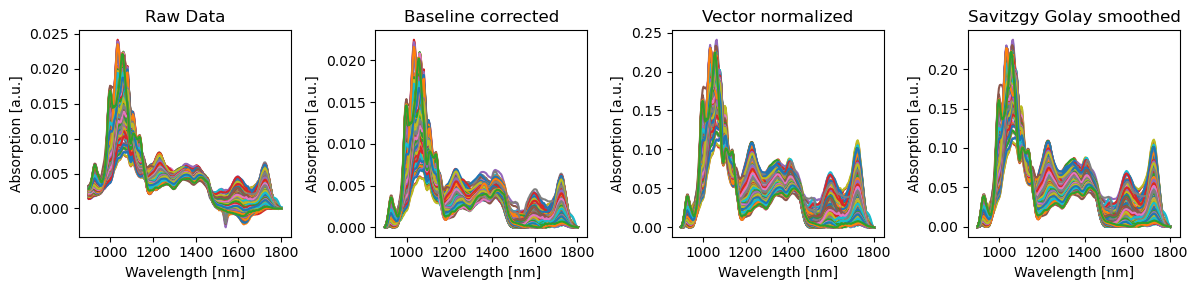

In [39]:
#Plottingfunction for the data, repeated after each step
def plotspec(X, dim, ax, title= None):    
    for i in range(len(X)):
        ax.plot(dim, X[i])
    ax.set(xlabel="Wavelength [nm]", ylabel="Absorption [a.u.]", title = title)

fig, (ax0, ax1, ax2, ax3) = plt.subplots(1, 4, sharex=True, figsize=[12,3])
plotspec(rawberry_no_cat.values, x, ax0, "Raw Data")
base_line_corrected = rubberband(rawberry_no_cat.values, x)
plotspec(base_line_corrected, x, ax1, "Baseline corrected")
vectorized = normalize(base_line_corrected)
plotspec(vectorized, x, ax2, "Vector normalized")
smoothed = savgol_filter(vectorized, 7, polyorder= 2)
plotspec(smoothed, x, ax3, "Savitzgy Golay smoothed")

strawberry_no_cat = pd.DataFrame(smoothed, index = rawberry.index, columns= rawberry_no_cat.columns)
strawberry_cat = rawberry_no_cat.copy()
strawberry_cat["Sample_Category"] = rawberry["Sample_Category"]

plt.tight_layout()
plt.show()




## Machine Learning
Here we aim to discern between two classes: "Non-Strawberry" and "Strawberry". This constitutes a supervised categorical machine learning task. In this notebook, two fundamental algorithms are applied: logistic regression and a decision tree. While the detailed workings of these algorithms are beyond the scope of this document, resources are available on [scikit-learn](https://scikit-learn.org/stable/). I selected these algorithms for their high interpretability, as my focus lies in understanding the differences between the categories rather than optimizing model performance.

Initially, I normalize the data using the StandardScaler class from sklearn. This process returns the z-values of the values as transformed values. Since the target labels are strings in the table, sklearn cannot handle them directly. Hence, I transform the data using a list comprehension. Subsequently, I split the data for validation using the accuracy metric at the end. Utilizing the scikit-learn API, I'll then train the models and obtain accuracy values to evaluate performance. Notably, I'll utilize LinearRegression with elastic net, setting a l1/l2 ratio of 0.5, which implies training the model with equal participation of lasso and ridge regularization.

In [40]:
# scale the data
scaler = StandardScaler()
X = strawberry_no_cat.values
X_scaled = scaler.fit_transform(X)

# get target-values in an array and convert into number format
y_string = strawberry_cat[strawberry_cat.columns[-1]]
y = np.array([0 if i == "NON-Strawberry" else 1 for i in y_string])

# split the data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2)

# initialize randomness
np.random.seed(21)
import random
random.seed(21)

In [41]:
# Initialize, train and evaluate Logistic regression
lm = LogisticRegression(solver="saga", penalty="elasticnet", l1_ratio=.5)
lm.fit(X_train, y_train)
y_predict = lm.predict(X_test)
acc_lm = accuracy_score(y_test, y_predict)

# Initialize, train and evaluate decision tree
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
y_predict = dt.predict(X_test)
acc_dt = accuracy_score(y_test, y_predict)

print("Accuracy of Linear regression: {:.2f}".format(acc_lm),
      "\nAccuracy of Decision tree: {:.2f}".format(acc_dt))

Accuracy of Linear regression: 0.96 
Accuracy of Decision tree: 0.92


/home/lukas/anaconda3/envs/IRspectralML/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Both models demonstrate strong performance, achieving accuracies of 97% and 93% respectively. This suggests that distinguishing between fake and authentic strawberry jam is relatively straightforward using these models. However, our focus lies in identifying the wavenumbers that have the most significant impact on model estimations. Fortunately, sklearn provides convenient access to model parameters, allowing us to extract the top 5 most important variables for each model.

In [42]:
# get top n features of both models
importances_lm = pd.Series(lm.coef_.reshape(235,), index=rawberry.columns[:-1])
importances_dt = pd.Series(dt.feature_importances_.reshape(235,), index=rawberry.columns[:-1])

n = 5
importances_lm_top = importances_lm.sort_values(ascending=False)[:n]
importances_dt_top = importances_dt.sort_values(ascending=False)[:n]

selected_features = sorted(set(importances_lm_top.index).union(set(importances_dt_top.index)))
selected_features

['1115', '1146', '1150', '1154', '1443', '1605', '910', '957']

## Statistical Testing of the identified features
After identifying the wavenumbers selected by the algorithms as the most informative, the next step is to validate this selection using statistical tests. In this process, I employ the independent t-test due to its common usage in comparing two populations. For performing the statistical test, I utilized the *annotate* package, which employed *scipy.stats* under the hood.

In [43]:
# generate pairs for statistical testing, drop values with very low absorbance
pairs = []
for feature in selected_features:
    pairs.append([(feature, "Strawberry"), (feature, "NON-Strawberry")])
pairs

[[('1115', 'Strawberry'), ('1115', 'NON-Strawberry')],
 [('1146', 'Strawberry'), ('1146', 'NON-Strawberry')],
 [('1150', 'Strawberry'), ('1150', 'NON-Strawberry')],
 [('1154', 'Strawberry'), ('1154', 'NON-Strawberry')],
 [('1443', 'Strawberry'), ('1443', 'NON-Strawberry')],
 [('1605', 'Strawberry'), ('1605', 'NON-Strawberry')],
 [('910', 'Strawberry'), ('910', 'NON-Strawberry')],
 [('957', 'Strawberry'), ('957', 'NON-Strawberry')]]

In [44]:
# change data format for visualization (pandas melt is useful here)
df = strawberry_cat[selected_features].copy()
df["cat"] = strawberry_cat["Sample_Category"]
df_melt = pd.melt(df, id_vars=["cat"], value_vars=df.columns[:-1], 
                  var_name="wavenumber", value_name="cm-1")
df_melt.head()

,cat,wavenumber,cm-1
0,NON-Strawberry,1115,0.007492
1,NON-Strawberry,1115,0.009876
2,NON-Strawberry,1115,0.007490
3,NON-Strawberry,1115,0.008006
4,NON-Strawberry,1115,0.007977


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

1146_NON-Strawberry vs. 1146_Strawberry: t-test independent samples, P_val:5.561e-06 t=-4.568e+00
1115_NON-Strawberry vs. 1115_Strawberry: t-test independent samples, P_val:1.181e-08 t=-5.751e+00
1150_NON-Strawberry vs. 1150_Strawberry: t-test independent samples, P_val:2.176e-08 t=-5.644e+00
1154_NON-Strawberry vs. 1154_Strawberry: t-test independent samples, P_val:1.340e-06 t=-4.864e+00
1443_NON-Strawberry vs. 1443_Strawberry: t-test independent samples, P_val:1.495e-67 t=-1.880e+01
1605_NON-Strawberry vs. 1605_Strawberry: t-test independent samples, P_val:5.255e-09 t=-5.892e+00
910_NON-Strawberry vs. 910_Strawberry: t-test independent samples, P_val:1.152e-10 t=-6.516e+00
957_NON-Strawberry vs. 957_Strawberry: t-test independent samples, P_val:5.054e-03 t=-2.810e+00


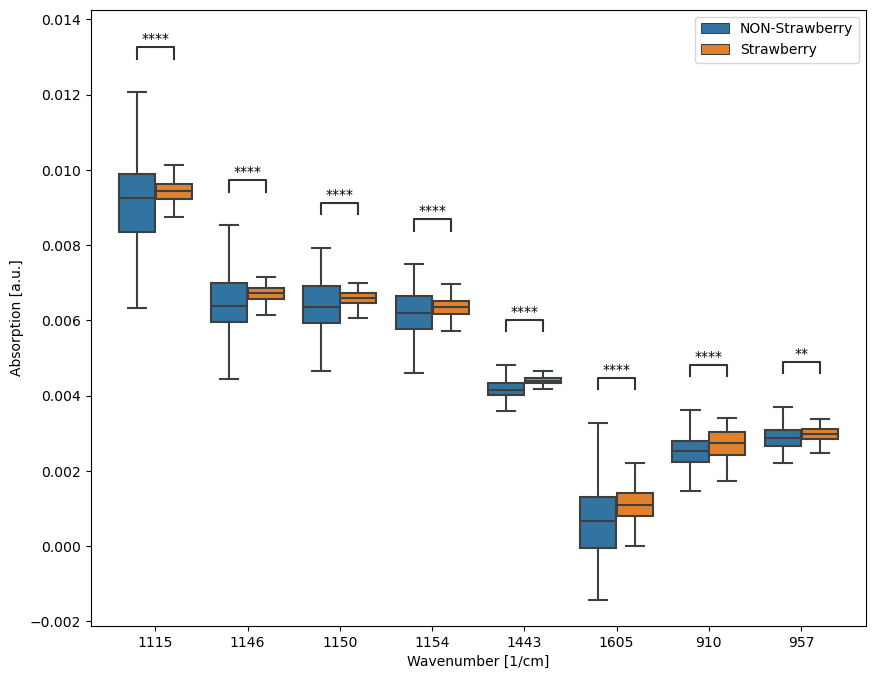

In [45]:
# create visualization
fig, ax1 = plt.subplots(figsize = [10,8])

x = "wavenumber"
y = "cm-1"
hue = "cat"
hue_order=["NON-Strawberry", "Strawberry"]
order = selected_features

ax1 = sns.boxplot(data = df_melt, y = y, x = x, hue = "cat", hue_order=hue_order, 
            order = order, showfliers = False)

# use the annotate package for statistical testing and annotation
annot = Annotator(ax1, pairs, data = df_melt, x = x, y = y, order = order, hue = hue, hue_order = hue_order)
annot.configure(test='t-test_ind', verbose=1, text_format='star', loc='inside',)
annot.apply_test()
annot.annotate()

ax1.legend().texts = None
plt.ylabel("Absorption [a.u.]")
plt.xlabel("Wavenumber [1/cm]")
plt.show()

## Conclusion
In this study, Logistic Regression and a Decision Tree algorithms were effectively employed to extract wavenumbers from IR spectral data. The resultant models demonstrated high accuracy, underscoring the efficacy of utilizing IR spectral data in tandem with machine learning techniques to distinguish between Strawberry and NON-Strawberry jam. Notably, various wavenumbers were found to exhibit statistically significant differences between the two subgroups, including. These wavenumbers were also chosen by the algorithms to be the most informative ones. Further investigation may shed light on the specific molecules responsible for these discernible distinctions.